In [4]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

/var/folders/vm/nv8sbsv139l8f506cd5jjw280000gn/T/ipykernel_88548/271102284.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms column has missing values. will deal with it later.
Besides, 'ocean_proximity' column is object, probably it's a cateorical attribute. Let's get count by categories.

In [9]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


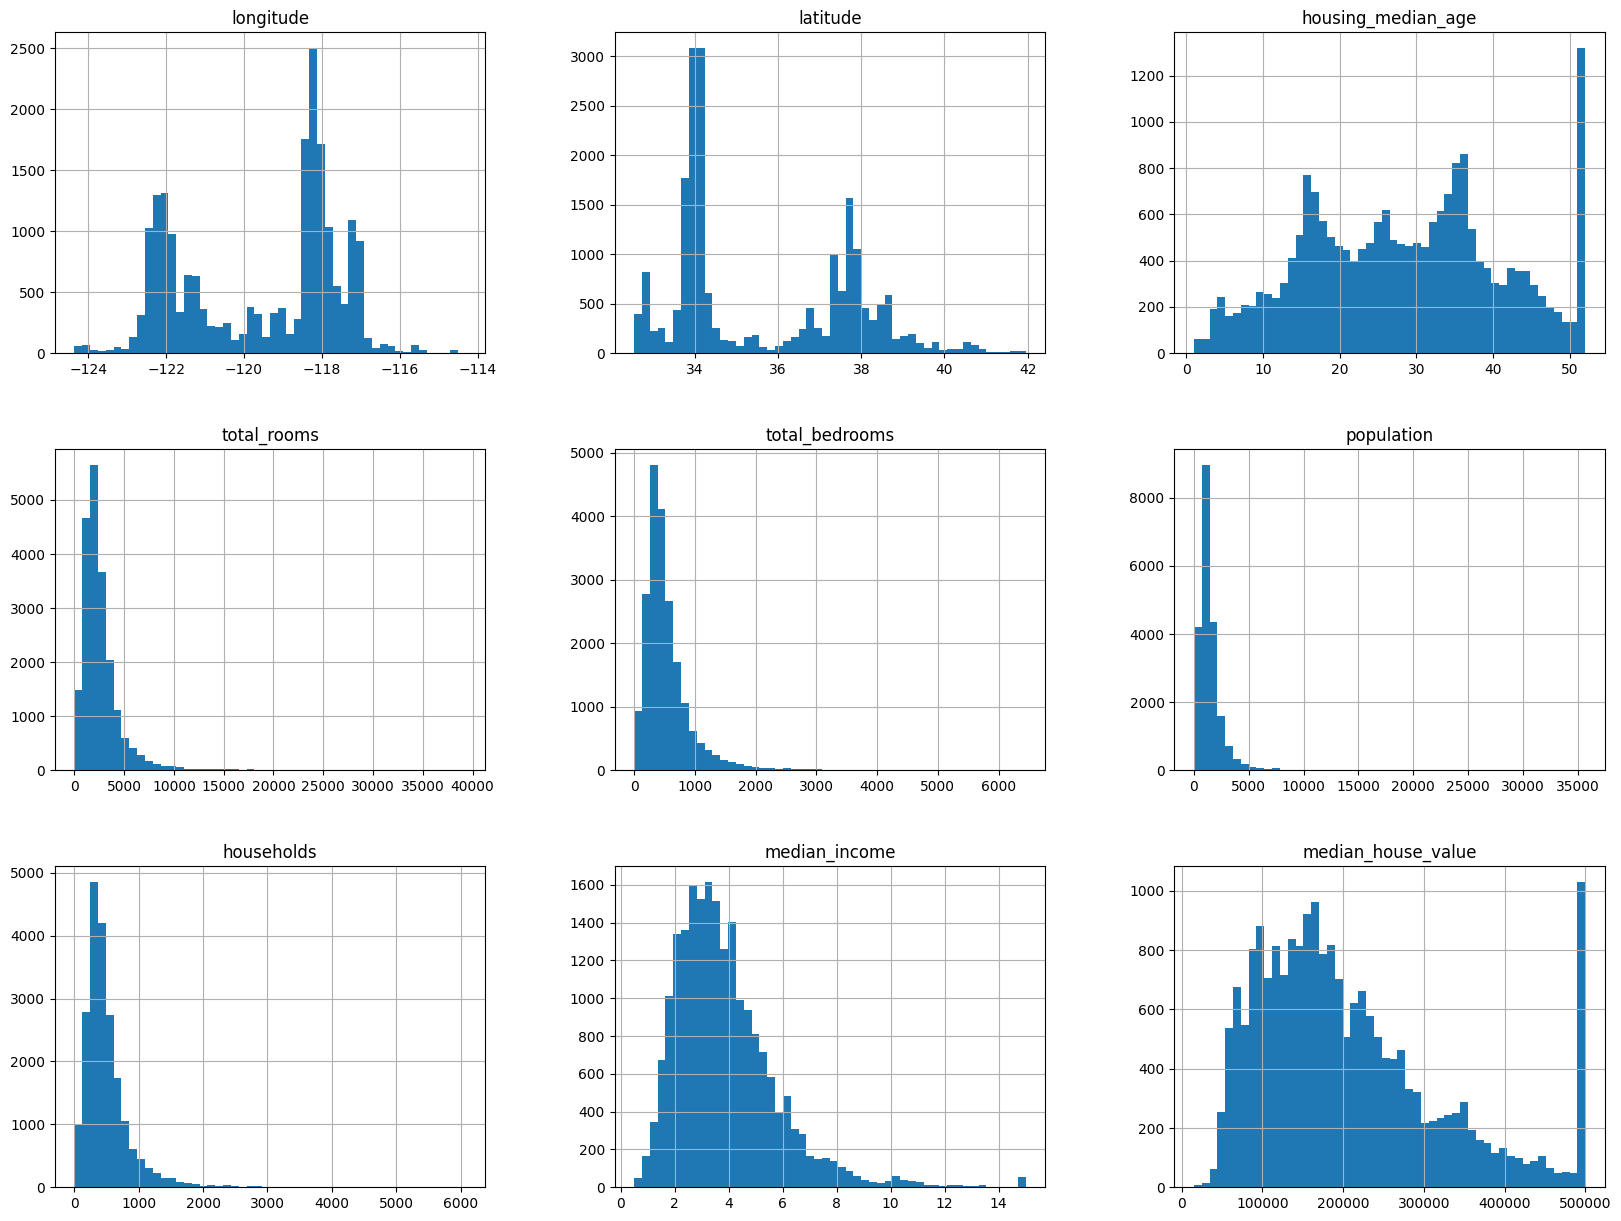

In [11]:

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Create a randomized test set! (To avoid bias)
Manual way of splitting to make sure the randomize and if there is same records make sure to split.

In [12]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [14]:
len(test_set)

4128

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=43)

In [16]:
print(len(train_set))
print(len(test_set))

16512
4128


We know that median income is the main feature to predict.
Need to make sure the stratified sampling is fairly done for each income category/range.

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

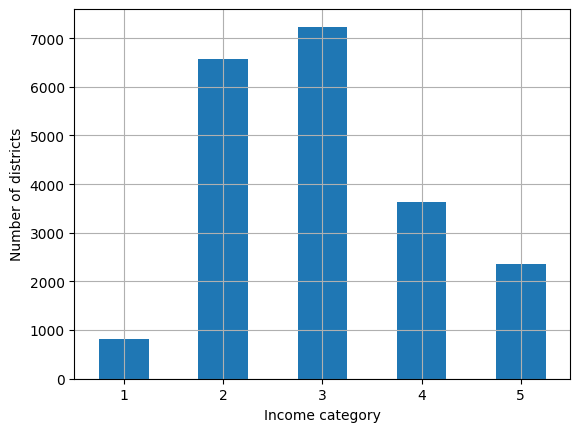

In [18]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [19]:
housing["income_cat"].value_counts() / len(housing["income_cat"])


income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [20]:
strat_train_set, strat_test_set = train_test_split(
housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [23]:
housing = strat_train_set.copy()

## Data visualization

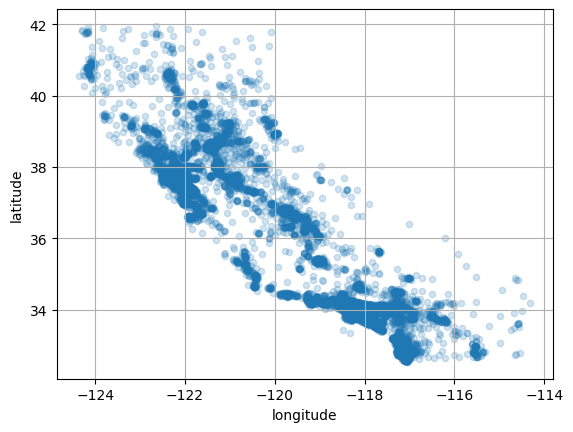

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2) # alpha for intensity to see dense
plt.show()

### Check with prices in colors

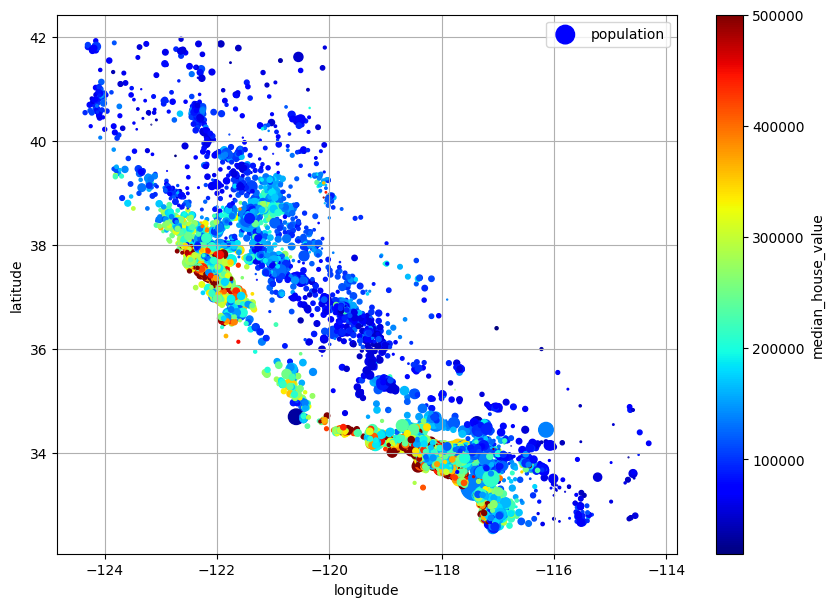

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

### Correlation

In [26]:
corr_matrix = housing.corr(numeric_only=True)

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

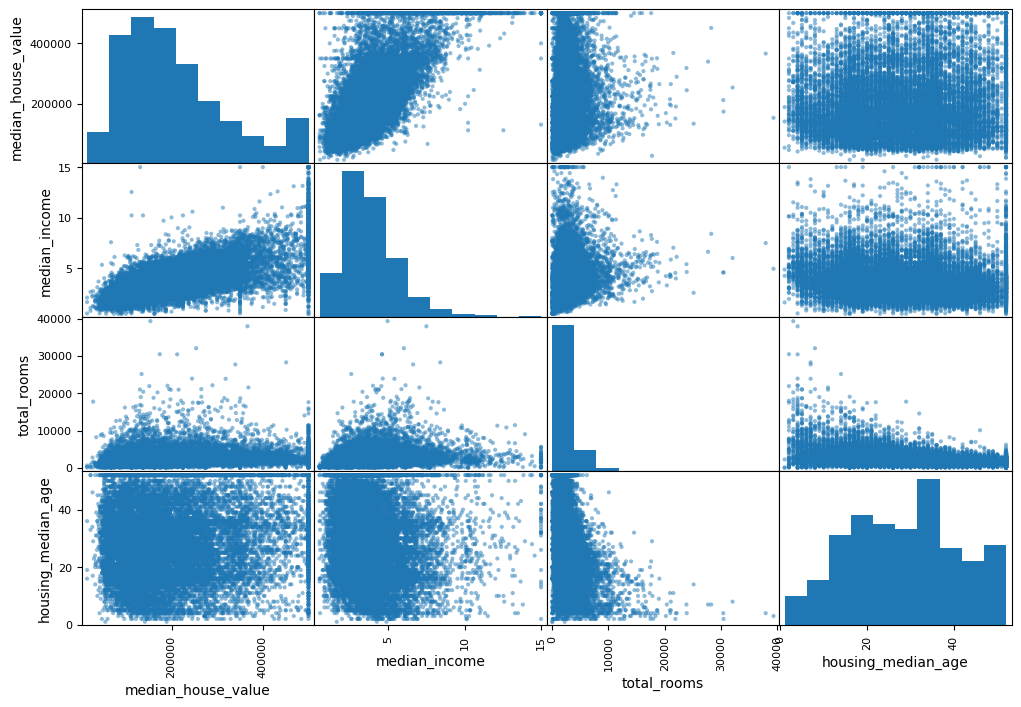

In [28]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

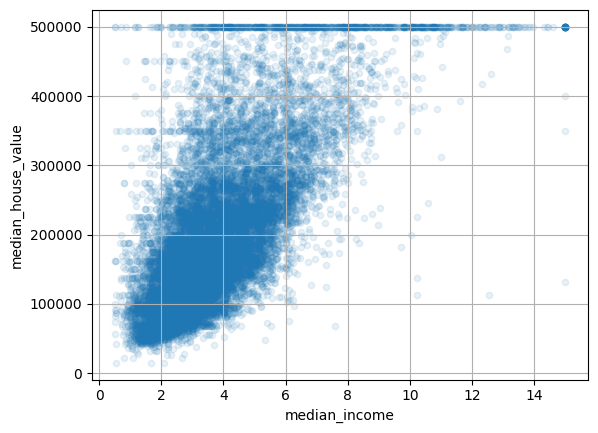

In [29]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1, grid=True)
plt.show()

From plots, apart from Linear pattern, there is some straight lines at 500K, 450k, 350k, 280k, and more.
We may want to clean them not to allow the ML model prediction disturbed.

### Now we can do bit of FEATURE engineering

In [30]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [31]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

In [32]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241


## Data preparation for ML

In [33]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Clean the data
- Missing values
- 

In [34]:
# housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

/var/folders/vm/nv8sbsv139l8f506cd5jjw280000gn/T/ipykernel_88548/4045544574.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


### Encode category text to number

In [35]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN


In [36]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [37]:
housing_cat_encoded[:8]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [40]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [41]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [42]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [43]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

### Feature scaling and transformation  

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # pretend this is new data
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [47]:
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [51]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [52]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
("impute", SimpleImputer(strategy="median")),
("standardize", StandardScaler()),
])

from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

### !!!Check the book for more transformers!!! ==> SUPER Cool features 

In [55]:
from sklearn.compose import ColumnTransformer
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
"total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", cat_pipeline, cat_attribs),
])

### TODO: Check Cluster Similarity!!!

In [54]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [57]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out
def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"), 
                         FunctionTransformer(column_ratio, feature_names_out=ratio_name), 
                         StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             FunctionTransformer(np.log, feature_names_out="one-to-one"),
                             StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]), 
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age

In [63]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [59]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [64]:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
housing_predictions = lin_reg.predict(housing)

In [66]:
housing_predictions[:5].round(-2) # -2 = rounded to the nearest hundred

array([ 64700., 288600., 183900., 190200., 269900.])

In [67]:
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [73]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

69122.90551084602

## DecisionTreeRegressor

In [74]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [75]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

## No error is impossible. We need to Cross-Validate

In [78]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [79]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66617.379266
std       3371.998183
min      58898.978399
25%      66076.908757
50%      66723.729529
75%      68962.894079
max      70678.472078
dtype: float64

## RandomForestRegressor

In [80]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [81]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47190.573246
std       2550.864528
min      43480.358064
25%      44896.667502
50%      47658.073694
75%      48989.061099
max      51084.213931
dtype: float64

## TODO: next topic - HYPER parameter tuning with GridSearchCV